# MF4056 / MF6013 Demo 1: Black-Scholes model calibration and simulation 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

rng=np.random.default_rng()

# Part 1: Sampling for a fixed risk-free rate $r$

Let $W$ be a standard Brownian motion. First, generate $10^{6}$ samples from the distribution of $W(T)$ with $T=1$.

In [2]:
M=10**6; T=1
WT=rng.normal(0,np.sqrt(T),M)

Convert to a sample of $S(T)=S_0e^{(\mu-\sigma^2/2)T+\sigma W(T)}$  

In [4]:
S0=1; mu=0.05; sig=0.2
ST=S0*np.exp((mu-0.5*(sig**2))*T+sig*WT)

Plot a histogram to show the empirical density of the sample

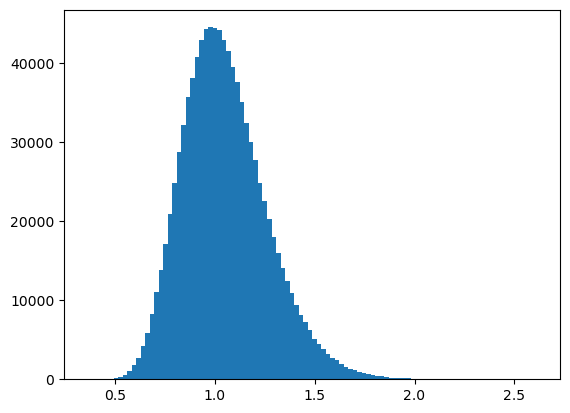

In [5]:
plt.hist(ST,bins=100)
plt.show()

Now we sample and visualise $M=20$ trajectories of $S$, where we make $N=100$ equally spaced observations on each trajectory.

In [6]:
M=20; N=100; T=1; dt=T/N
increments=rng.normal(0,np.sqrt(dt),size=(M,N))
increments

array([[ 0.02069857, -0.06592818, -0.18242381, ..., -0.03555519,
         0.01256122, -0.10217706],
       [-0.11149132,  0.08604123, -0.02612907, ...,  0.03138451,
        -0.00149688, -0.08668501],
       [ 0.01957624, -0.07627737,  0.08629338, ...,  0.05572276,
        -0.17945485, -0.01999889],
       ...,
       [-0.12952446,  0.24678813, -0.03850345, ...,  0.15738613,
        -0.12258984,  0.08820068],
       [ 0.11320083, -0.00693999,  0.06085687, ...,  0.11595411,
        -0.10166196,  0.04314537],
       [-0.08098937,  0.00705356, -0.02988526, ..., -0.05640987,
        -0.05147471,  0.01662602]])

Each value in the array 'increments' represents a specific observation on $W((n+1)dt,\omega_i)-W(ndt,\omega_i)$, for $n=0,\ldots,N-1$ and $i=0,\ldots,M-1$.

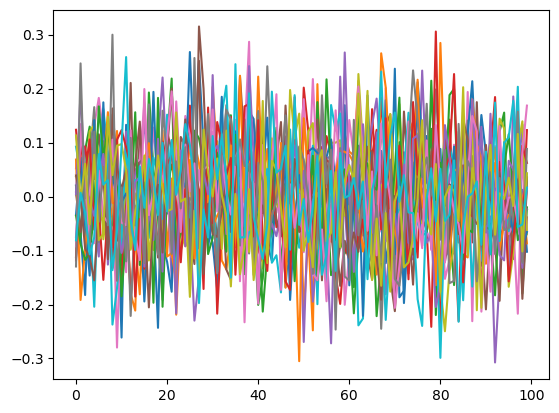

In [7]:
plt.plot(increments.T)
plt.show()

Since the time axis is indexed by the number of steps, define a time array and plot against that.

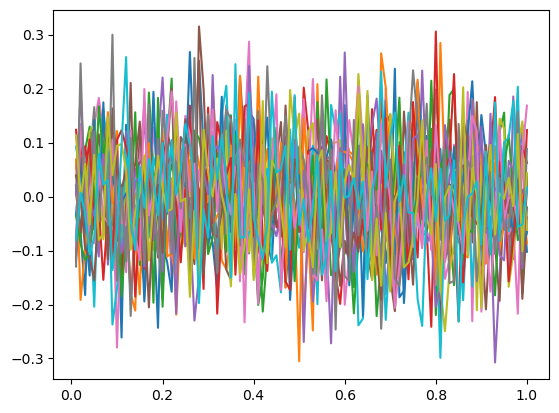

In [8]:
t=np.linspace(dt,1,N)
plt.plot(t,increments.T)
plt.show()

Now generate $M$ trajectories of $W$ starting at time $dt$ (not at zero), by taking the cumulative sum of the increment array.

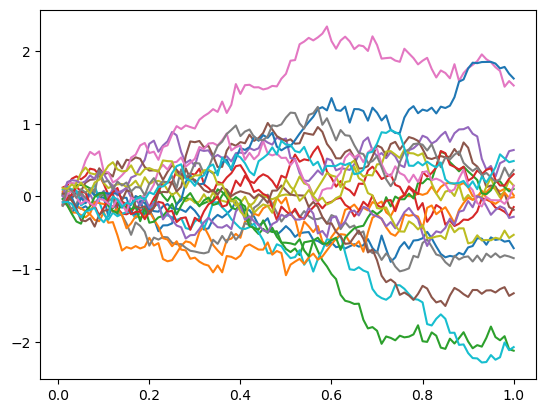

In [9]:
W=np.cumsum(increments,axis=1)
plt.plot(t,W.T)
plt.show()

Since there is no initial value yet either for $t$ or $W$, prepend them.

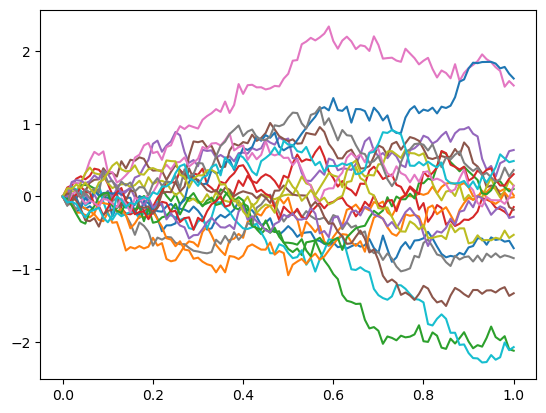

In [10]:
t=np.insert(t,0,0)
W=np.c_[np.zeros(M),W]
plt.plot(t,W.T)
plt.show()

Now convert $W$ and $t$ to the ensemble of Black-Scholes asset trajectories $SS.

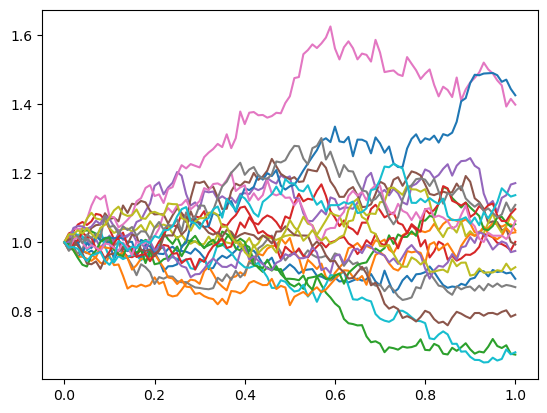

In [11]:
S=S0*np.exp((mu-0.5*sig**2)*t+sig*W)
plt.plot(t,S.T)
plt.show()

# Part 2: Calibrating the model off a term structure

From Table 1 in Notes Set 1, set up array variables containing bond maturities and corresponding zero-rates 

In [12]:
mat=np.array([0.5,1.0,1.5,2.0])
rates=np.array([0.02,0.022,0.025,0.03])

The time-$t$ value of a zero-coupon bond with face value $P(T,T)=100$ maturing at time $T$ is $100\times e^{-r_T(T-t)}$. Create an array of bond prices:

In [13]:
def dFac(r,dt):
    return np.exp(-r*dt)

bonds=100*dFac(rates,mat)

Construct a time set $[T_0,T_1,T_2,T_3,T_4,T_5]$ and array of bond values $P(0,0),P(0.0.5),P(0,1.0),P(0,1.5),P(0,2.0)$

In [36]:
t=np.insert(mat,0,0)
bonds=np.insert(bonds,0,100)

array([0. , 0.5, 1. , 1.5, 2. ])

Now simulate the asset at $6$-month intervals to be consistent with these bond values, and plot. 

In [15]:
T = 2.0; sig = 0.3
N = 4; dt=T/N       

In [48]:
inc

array([ 0.0623464 ,  0.81242926, -0.00344278, -0.37823811])

In [16]:
inc = rng.normal(0,np.sqrt(dt),N)
S = np.ones(N+1)
factor = np.exp(-0.5*(sig**2)*dt+sig*inc)
bondRatio = bonds[:-1]/bonds[1:]
update = bondRatio*factor

In [17]:
for i in range(N):
    S[i+1] = S[i]*update[i]

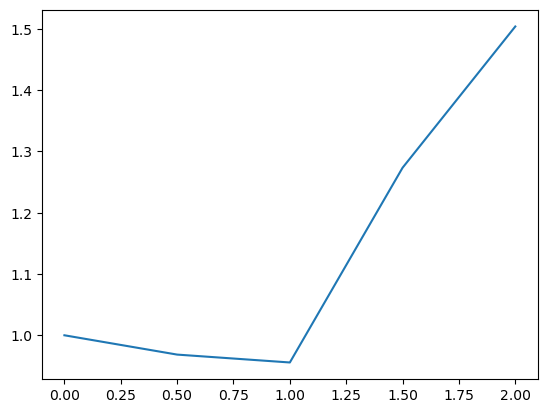

In [18]:
plt.plot(t,S.T)

### My Workings Q1

In [40]:
inc = rng.normal(0,np.sqrt(dt),N)
S = np.ones(N+1)
factor = np.exp(-0.5*(sig**2)*t[1:]+sig*inc)



In [43]:
bondRatio = bonds[0]/bonds[1:]
bondRatio

array([1.        , 1.01005017, 1.02224378, 1.038212  , 1.06183655])

In [32]:
S[:-1]

array([1.        , 1.12242677, 1.53755518, 1.87378761, 2.48648895,
       2.42794226, 2.08484437, 2.7672517 ])

In [35]:
bonds[0]


100.0

In [55]:
inc = rng.normal(0, np.sqrt(dt), N)
S = np.ones(N+1)
factor = np.exp(-0.5 * (sig**2) * t[1:] + sig * inc)
bondRatio = bonds[0] / bonds[1:]
update = bondRatio * factor

S[1:] = np.cumprod(update)


ValueError: operands could not be broadcast together with shapes (5,) (4,) 

# Part 3: Interpolating the trajectories of a calibrated model

How do we generate quarterly values for $S$ calibrated to the same set of bond values? We can interpolate to get intermediate values. Create a new time set and interpolated bond values. This is done indirectly by linear interpolation of the yield curve.

In [19]:
matNew=np.arange(0.25,2.25,0.25)
ratesNew=np.interp(matNew,mat,rates)
bondsNew=100*dFac(ratesNew,matNew)
print(ratesNew)

[0.02   0.02   0.021  0.022  0.0235 0.025  0.0275 0.03  ]


Since there is no value for $r_0$  from which to interpolate between $T=0$ and $T=0.5$, the value for $r_{0.5}$ is reused for $r_{0.25}$. This is not ideal - the short rate at time $T=0$ would be better, though it is not provided in the data available.

In [20]:
tNew=np.insert(matNew,0,0)
bondsNew=np.insert(bondsNew,0,100)

Now generate trajectories of $S$ over the expanded time set and plot.

In [21]:
N=8; dt=0.25;
S=np.ones(N+1)

In [22]:
inc = rng.normal(0,np.sqrt(dt),N)
factor = np.exp(-0.5*(sig**2)*dt+sig*inc)
bondRatio = bondsNew[:-1] / bondsNew[1:]
update = bondRatio*factor

In [23]:
for i in range(N):
    S[i+1] = S[i]*update[i]

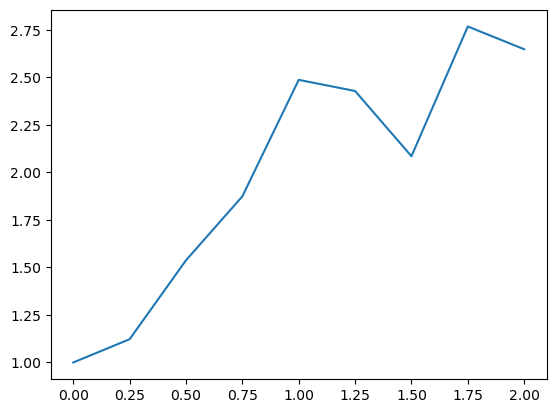

In [24]:
plt.plot(tNew,S.T)

After interpolation, notice that we have moved to a new trajectory, since we resampled the Brownian increments $\Delta W$. If we wish to stay on the same trajectory, we must find a way to interpolate $W$.

# Part 4: Interpolation of the Brownian path 

First, generate the Brownian trajectory at low resolution and store in the array variable $W$

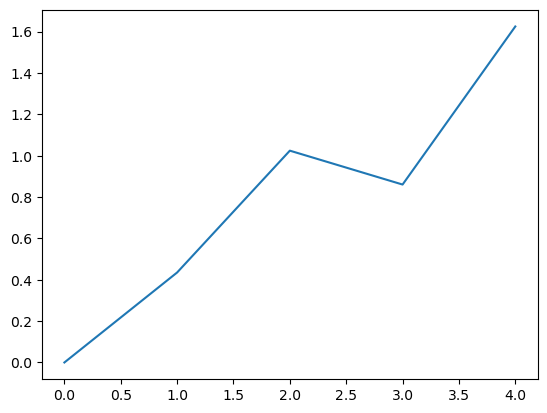

In [25]:
T = 2.0; N = 4; dt = T / N
inc = rng.normal(0, np.sqrt(dt), N)
W = np.insert(np.cumsum(inc),0,0)
plt.plot(W);plt.show()

Next, expand $W$ to accommodate the extra values by inserting a placeholder zero at every second position in the array

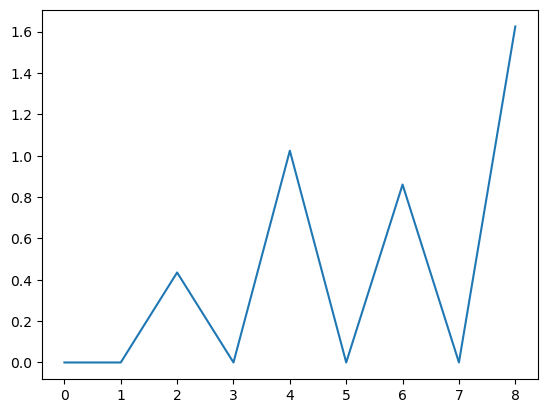

In [26]:
Wbridged = np.insert(np.zeros(N+1),np.arange(N+1), W)[:-1]
plt.plot(Wbridged);plt.show()

What does [:-1] do here?

Next set up a new time set $t$ with the correct time points

In [27]:
N1=2*N; dt=T/N1; t=np.arange(0,T+dt,dt)

Define a function based upon Theorem 1.1 in Notes Set 1 that we can call in order to generate the bridged observation.

In [28]:
def b_bridge(t1,t,t2,x1,x2):
    Z = rng.normal(0,np.sqrt((t2-t)*(t-t1)/(t2-t1)),1)
    return ((t2-t)*x1+(t-t1)*x2)/(t2-t1)+Z

Now use a for loop to insert bridged observations at each odd indexed entry of the array.

In [29]:
for i in range(1,len(Wbridged),2):
    Wbridged[i]=b_bridge(t[i-1],t[i],t[i+1],Wbridged[i-1],Wbridged[i+1])

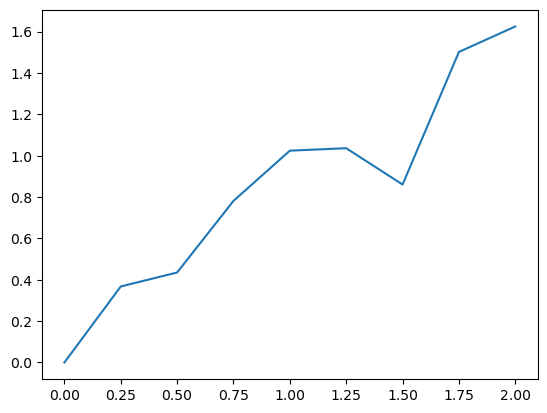

In [30]:
plt.plot(t,Wbridged.T)